# LGT2 Unit 11 Day 01 - Pre-Class Assignment
# Nucleon Charges in Lattice QCD
### <p style="text-align: right;"> &#9989; Put your name here.</p>

In [ ]:
#--Run this cell to import your libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm

## Goals of this assignment
The goals of this assignment are:

* Gain practice and familiarity with analyzing two- and three-point correlator data in Lattice QCD.
* Learn about nucleon charges and how they are extracted from lattice data.
* Explore fitting techniques for two- and three-point correlators.

## Assignment instructions
For this assignment, please:
1. Watch the embeded lecture videos before starting the assignment.
2. Work through the coding tasks, properly commenting your work and labeling the axes on your graphs.
3. Complete this assignment before noon of the class day.

----
# Part 1: Introduction to Nucleon Charges in Lattice QCD

Nucleon charges provide insight into the internal structure of nucleons, making them essential for understanding key aspects of nuclear and particle physics. These charges contain information about the quark content of nucleons and their interactions with fundamental forces, playing a large role in Standard Model tests and Beyond the Standard Model searches. In this section, we'll introduce several nucleon charges which commonly appear in lattice calculations: the isovector axial ($g_A^{u-d}$), isovector scalar ($g_S^{u-d}$), and isovector tensor charges ($g_T^{u-d}$).

The isovector axial charge, plays a critical role in neutron beta decay and is a key input for determining the strength of weak interactions in nuclear environments. Precise lattice QCD calculations of the axial charge serve as benchmarks for experimental measurements and help refine our understanding of fundamental symmetries, such as chiral symmetry breaking. Similarly, the scalar charge is of interest in searches for beyond-the-Standard-Model physics, particularly in the context of nucleon interactions with hypothetical scalar particles, while the tensor charge is a crucial ingredient in studies of transverse spin structure and potential electric dipole moments of the nucleon. In the following lecture video, we will discuss these charges a litle more in-depth and we'll cover methods used to extract them from lattice data.

Watch the lecture video below:

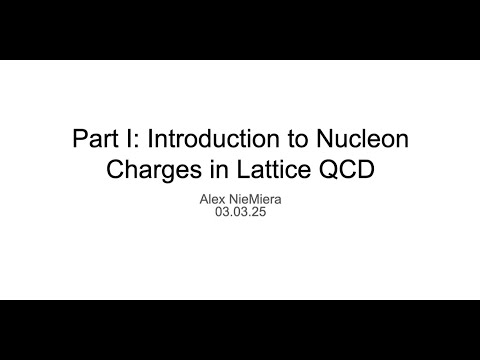

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("p12nwropY-k",width=640,height=340)

Now that you're familiar with nucleon charges, let's get to work!

Lattice correlators can be stored in various formats. Text files are human-readable but inefficient for large datasets, as they take up more space and are slow to process. To address this, binary formats like HDF5 (.h5) are commonly used in computational research, but for now, we'll focus on a simple ASCII format.

Download the data:
<br>
* Two-Point Correlator: https://drive.google.com/open?id=1qmHUbSAWmjIwR7Xlur7CPoADsholhf4Z <br>
* Three-Point Correlator ($t_\text{sep} = 8$): https://drive.google.com/open?id=12RfmOuxQe3BI80vg6faOgbtJWOuhKips <br>

The first line of the data file contains metadata, with only the first two numbers being relevant. The first number represents the total number of configurations (ncfgs), while the second number corresponds to one-fourth of the temporal extent of the lattice. Each configuration in the dataset spans $L_t/4$ time slices, meaning the time index does not run continuously from $t = 0$ to $t = L_t - 1$ across the entire dataset. Instead, for each configuration, the time values range from $t = 0$ to $L_t/4 - 1$, after which they reset to $t=0$ for the next configuration. Beyond the first row, we have the correlator data. The first column indicates the Euclidean time $t$, with the ordering we discussed above, the second column is the real part of the correlator data, and the third column is the imaginary part of the correlator data.

In addition to these data files, you are also provided with several functions throughout the notebook as the primary goal of this exercise is to become familiar with the data analysis process rather than writing your own code. However, be sure to take a moment to look at these functions and try to understand them as you proceed through the notebook. Our in-class exercise will build off of this pre-class work!

In [ ]:
def jack(data):
    n = len(data)
    jack_data = [(np.sum(data)-data[i])/(n-1) for i in range(n)]
    return np.array(jack_data)

In [ ]:
def jack_stats(jack_data):
    jack_data = np.asarray(jack_data)

    if jack_data.ndim == 1:
        n = len(jack_data)
        mean  = np.mean(jack_data)
        error = np.sqrt( (n - 1) / n * np.sum((jack_data - mean) ** 2) )
        return mean, error

    elif jack_data.ndim == 2:
        m, n  = jack_data.shape  # m: rows (time), n: columns (subsets)
        mean  = np.mean(jack_data, axis=1)
        error = np.sqrt( (n - 1) / n * np.sum((jack_data - mean[:, None]) ** 2, axis=1) )
        return mean, error
    else: raise ValueError("Input data must be either 1D or 2D array.")

### Task 1.1: Read in the Data
* Write a function called `load_correlator_data()` to read in the two-point and three-point data files. Your function should do the following:
    * Organize the real part of the data such that you have time along the rows and configurations along the columns.
    * For each time, use the function `jack()` to apply jackknife resampling to the correlator data.
    * Using `jack_stats()`, get the mean and error associated with the jackknife resampled configuration at each time.

* Identify and globally define `time` and `ncfgs` from the datafile.

&#9998; *Student Solution...*

In [ ]:
time  =
ncfgs =

def load_correlator_data(filename):
    # add your code here...
    return corr_jack, corr_mean, corr_std

### Task 1.2: Plot the Raw Data
It's always a good idea to plot our data and make sure everything looks ok before we start our analysis!
* Using the function from Task 1, plot the mean and error of the two- and three-point correlators. You'll want to plot the two-point correlator in log scale. (Suggestion: use `plt.errorbar()` for the plotting). For consistency, stick with the naming scheme I provide in the cell below.

&#9998; *Student Solution...*

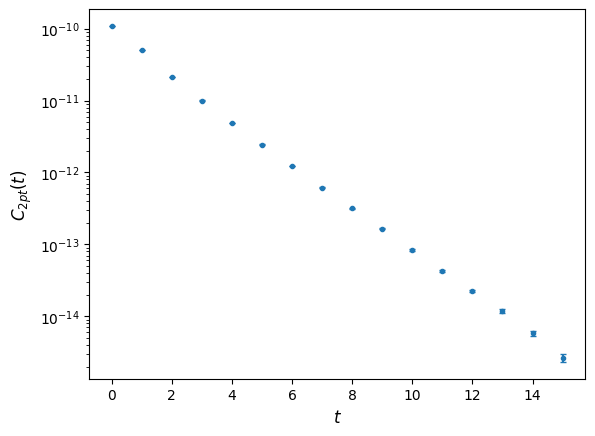

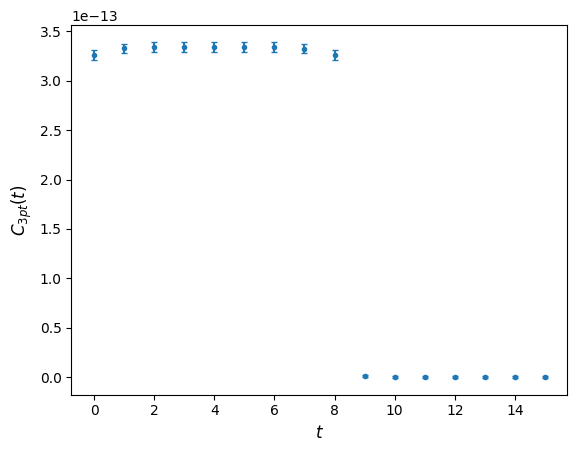

In [ ]:
C2pt_jack, C2pt_mean, C2pt_std = load_correlator_data('proton.D-694.DG5p5_3.DG5p5_3.SS')
C3pt_jack, C3pt_mean, C3pt_std = load_correlator_data('NUCL_V_MIXED_NONREL_l0_g8_qx0_qy0_qz0.t8')

# plot the raw correlator data.

----
# Part 2: Fitting Correlators

In the last lecture video, we were introduced to the spectral decompositions of the two-point correlator:

$$ \tag{2.1}
C_{\text{2pt}} (t_{\text{src}}, t_{\text{snk}})
= \sum_n \left[ \frac{\langle \Omega | \chi^N (\vec{z}, t_{\text{snk}}) | n \rangle \langle n | \bar{\chi}^N (\vec{x}, t_{\text{src}}) | \Omega \rangle }{2E_n} \right] e^{-E_n (t_{\text{snk}} - t_{\text{src}})}
$$

and of the three-point correlator:

$$ \tag{2.2}
C_{\text{3pt}} (t_{\text{src}}, t_{\text{ins}}, t_{\text{snk}}) = \sum_{n,m} \left[ \frac{\langle \Omega |  \chi^N \left(\vec{z},t_{\text{snk}}\right) | n \rangle \langle n | \mathcal{O} \left(\vec{y},t_{\text{ins}}\right) | m \rangle \langle m | \overline{\chi}^N  (\vec{x},t_{\text{src}} ) | \Omega \rangle}{4 E_n E_m} \right] e^{-E_n (t_{\text{snk}} - t_{\text{src}})} e^{-E_m (t_{\text{ins}} - t_{src})}
$$

These sums contain contributions from an infinite tower of excited states, but in most practical situations, we are interested in extracting the properties of the ground state or the lowest few excited states. The challenge is that the data contain statistical fluctuations, and simple inspection is not sufficient to isolate individual contributions. By fitting the correlators to appropriate functional forms, which we will learn about in this lecture video, we can determine matrix elements relevant for extracting nucleon charges and improve signal quality by isolating and reducing excited state contamination. In this section, we will discuss the commonly used fit forms and fitting procedures for extracting physical information from two- and three-point correlators.

Watch the lecture video below:

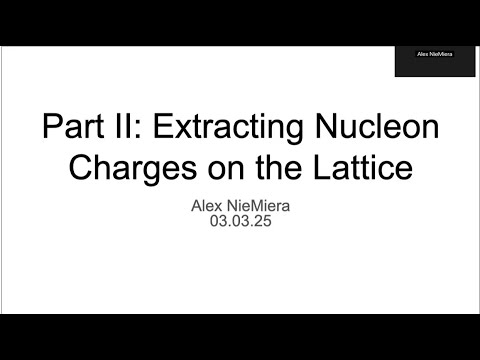

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("7RjzwjLSMMQ",width=640,height=340)

## Part 2.1: Two-Point Correlator Review
In the second lecture video, we saw that we can write the two-point correlator as,

$$ \tag{2.3}
C_{\text{2pt}} = |A_0|^2 e^{-E_0 t} + |A_1|^2 e^{-E_1 t}
$$

where the first term represents the contribution from the ground state, while the second term accounts for excited-state contamination. By including the excited-state term, we can systematically reduce contamination and extract a more precise value for the ground-state energy $E_0$.

$$ \tag{2.4}
M_{\text{eff}} (t) = -ln \left( \frac{C_{\text{2pt}}(t + 1)}{C_{\text{2pt}} (t)} \right)
$$

This quantity provides an estimate of the nucleon mass and helps assess the behavior of the correlator. By examining the plateau region in the effective mass plot, we can determine whether excited-state contamination is sufficiently suppressed and identify a reliable fitting window.

### Task 2.1: Plotting the Effective Mass
* Use the provided `EM()` function to compute and plot the effective mass with error bars. (Hint: Apply this function to each jackknife resampled set of data.)
* Estimate the nucleon mass by averaging over the plateau region in your graph.
* Based on your plot, determine a suitable fitting window for determining the ground state energy. Provide a justification for your choice in a markdown cell below.

&#9998; *Student Solution...*

Add your explanation here...

In [ ]:
# no need to change anything in this cell...
def EM(data):
    T = len(data)
    Meff = [-1 * math.log(data[t+1]/data[t]) for t in range(0,T-1)]
    return np.array(Meff)

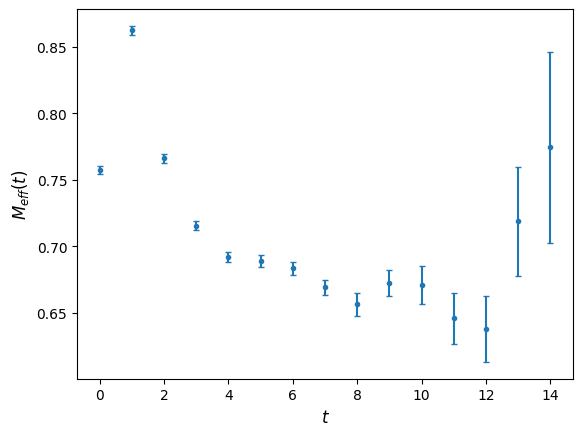

In [ ]:
EM_jack = # add your code here...
EM_mean, EM_std = jack_stats(EM_jack)

# plot the effective mass...

### Task 2.2: Fitting the Correlator
* Finish writing the function `C2pt_model()` using a **two-state** fit form.
* Using `C2pt_model()` and the fitting window you identified in Task 1, fit the correlator data with `Fit2ptCorr(fit_range)`. Plot your reconstructed effective mass with error bands over the lattice data and comment on what you observe.
* How does the mean of your jackknife fitted ground state energies compare to the average you took over the platue region in Task 1?

&#9998; *Student Solution...*

In [ ]:
def C2pt_model(t,A0,E0,A1,dE):
    E1 = E0 + abs(dE) # enforces E1 > E0
    return # finish writing this function...

In [ ]:
# You don't need to change anything in this cell...
def Fit2ptCorr(fit_range):
    tmin, tmax = fit_range
    C2pt_mean, C2pt_std = jack_stats(C2pt_jack)
    fit_params = []
    for cfg in tqdm(range(0,ncfgs)):
        popt, pcov = curve_fit(lambda t, A0, E0, A1, dE: C2pt_model(t, A0, E0, A1, dE),
                       xdata = time[tmin:tmax+1],
                       ydata = C2pt_jack[:,cfg][tmin:tmax+1],
                       sigma = C2pt_std[tmin:tmax+1],
                       p0    = [1e-3,0.5,1e-3,0.5],
                       maxfev= 500000)
        fit_params.append(popt)
    return np.array(fit_params)

100%|██████████| 253/253 [00:01<00:00, 174.00it/s]


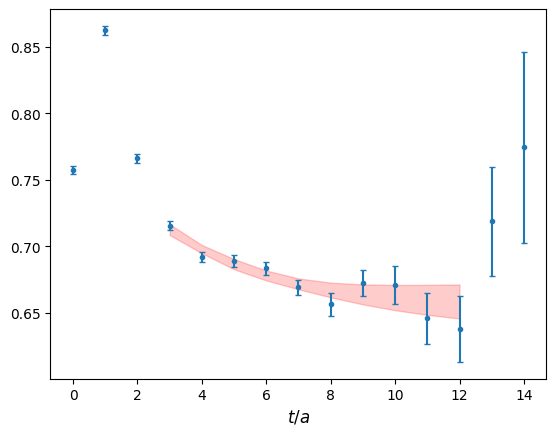

In [ ]:
def Reconstruct_EM(fit_range):
    tmin, tmax = fit_range
    fit_time   = time[tmin:tmax+1]

    params = Fit2ptCorr(fit_range)

    fits = # fill this portion of the code in...
    fit_mean, fit_std = jack_stats(fits)

    EM_jack = # fill this portion of the code in...
    EM_mean, EM_std = jack_stats(EM_jack)

    # plot your results....

fit_range = # what is an appropriate fit rnage?
Reconstruct_EM(fit_range)

## Part 2.2: Three-Point Correlator
In the second lecture video, we saw that we can write the two-point correlator as,

$$ \tag{2.5}
C_{\text{3pt}}^{\text{model}} (t, t_{\text{sep}}) = \mathcal{M}_{00} |A_0|^2 e^{-E_0 t_{\text{sep}}} + \mathcal{M}_{01} |A_0| |A_1| e^{-E_0 t_{\text{sep}}} e^{-E_1 (t_{\text{sep}} - t)}
$$

$$ + \mathcal{M}_{10} |A_0| |A_1| e^{-E_1 t_{\text{sep}}} e^{-E_0 (t_{\text{sep}} - t)} + \mathcal{M}_{11} |A_1|^2 e^{-E_1 t_{\text{sep}}}
$$

Similar to the effective mass analysis for the two-point correlator, we can use the ratio of the two- and three-point correlators as a diagnostic tool to validate our fits,

$$ \tag{2.6}
R(t, t_{\text{sep}}) = \frac{C_{\text{3pt}}(t, t_{\text{sep}})}{C_{\text{2pt}}(t_{\text{sep}})}
$$

Since the numerator and denominator share similar excited-state contributions, their effects partially cancel in the ratio, making it useful for isolating the dominant ground-state contribution. By plotting $R(t, t_{\text{ins}})$ against $t - t_{\text{sep}}/2$, we can identify a plateau region around $t \approx t_{\text{sep}}/2$, from which we can extract an estimate for the ground state matrix element, $\mathcal{M}_{00}$.

### Task 2.3: Plotting the Ratio
* Write a function to calculate the ratio by applying Equation 2.6 to each jackknifed re-sampled dataset. Your function should return the mean and error of these jackknifed ratios.
* Plot the mean and error using $t - t_{\text{sep}}/2$ along the x-axis and zooming in on the region of interest by only plotting relevent data points from $t = \{1, t_{sep}-1 \}$.
* Identify the plateau region and estimate it's value by taking an average across these central points.

&#9998; *Student Solution...*

Estimated O00 = 1.0544329324465065


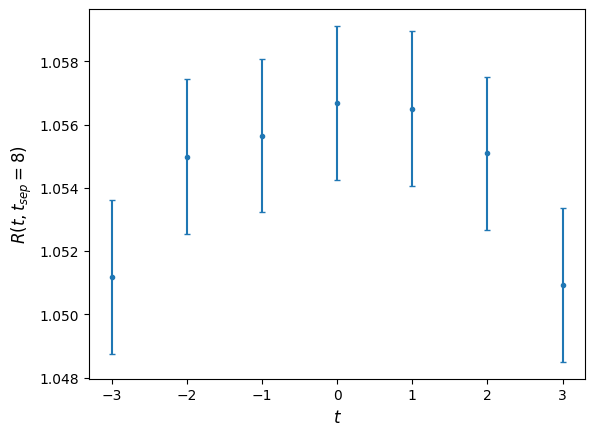

In [ ]:
def ratio(tsep, C3pt_jack, C2pt_jack):
    R = # fill this in...
    R_mean, R_std = jack_stats(R)
    return R_mean, R_std

# plot your results and estimate the ground state matrix element

In the lecture video, we discussed the importance of doing a simultaneous fit across multiple separation times, however, to keep this pre-class assignment simple, we'll only fit with one separation time. Additionally, we'll continute to use the **one-state** fit form for the three point correlator. In class, we'll work together to extend our analysis to using the two-state fit forms and performing a simultaneous fit across multiple separation times.

### Task 2.4: Fitting the Correlator
* Finish writing the function `C3pt_model()` using the **one-state** fit form.
* Using `C3pt_model()` and the jackknife fit parameters from Part 2.1, fit the correlator data with `Fit3ptCorr(tsep)`.
* Take the mean and jackknife error of your ground state matrix element, `O00`. How does this compare to the value you obtained by taking the average across the platue of the ratio plot in Task 1?

&#9998; *Finish writing the cell of code below...*

In [ ]:
def C3pt_model(t, A0, E0, O00):
    return # fill this in...

In [ ]:
def Fit3ptCorr(tsep, A0, E0):
    fit_params = []
    for cfg in range(ncfgs):
        popt, pcov = curve_fit(lambda t, O00: C3pt_model(tsep, A0[cfg], E0[cfg], O00),
            xdata=time,
            ydata=C3pt_jack[1:tsep,cfg],
            sigma=C3pt_std[1:tsep],
            p0=[0.1],
            maxfev=500000)
        fit_params.append(popt)
    return np.array(fit_params)

In [ ]:
# print out your fitted ground state matrix element

-----------------------
# Assignment Wrap-up

Submit this assignment by uploading it to the course [Gradescope course page](https://www.gradescope.com/courses/987121). Please **fill out the following Google Form when you complete this assignment**; questions submitted into the GoogleForm before noon EST of the class day will be addressed by the instructor in the beginning of the class.

In [ ]:
from IPython.display import HTML
HTML(
"""
<iframe
	src="https://forms.gle/jrEJKdByFRxAsNpU9"
	width="80%"
	height="1200px"
	frameborder="0"
	marginheight="0"
	marginwidth="0">
	Loading...
</iframe>
"""
)



----

#Congratulations, you're done!

&#169; Copyright 2025,  Michigan State University Board of Trustees